## Wrangling and Analyzing WeRateDogs Twitter Data

- #### <a href='#DW'>1. Data Wrangling</a>
    - <a href='#DW'>1.1 Gathering Data</a>
    - <a href='#AS'>1.2 Assessing Data</a>
    - <a href='#CD'>1.3 Cleaning Data</a>

- #### <a href='#CSV'>2. Storing Data</a>
- #### <a href='#AD'>2. Analyzing Data</a>

In [1]:
# Import packages
import pandas as pd
import numpy as np
import requests
import os
import tweepy
import json
import matplotlib.pyplot as plt

% matplotlib inline

## 1. Data Wrangling <a id='DW'></a>
### 1.1 Gathering Data
First we'll gather data for this project from 3 different sources on 3 dataframe: <p>
- <b>df1</b>: WeRateDogs Twitter archive read from downloaded csv file 'twitter-archive-enhanced'.
- <b>df2</b>: Tweets image predictions programmatically downloaded from Udacity server as 'image_predictions.tsv'.
- <b>df3</b>: retweet and favorite count queried using twitter API and stored as JSON file 'tweet_json.txt'.

In [2]:
### df1
# Read CSV file
df1 = pd.read_csv('twitter-archive-enhanced.csv')
df1.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [3]:
### df2
# Download from this URL:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open(url.split('/')[-1], mode = 'wb') as file:
    file.write(response.content)

# Read file with its name taken from the last part of the URL
df2 = pd.read_csv(url.split('/')[-1], sep = '\t')
df2.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [ ]:
### df3
# Twitter API code

import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [4]:
# Store json data in dictionary to convert to pandas df
dic = []

with open('tweet-json.txt') as json_file:
    for r in json_file:
        data = json.loads(r)
        dic.append({'tweet_id': data['id'],
                    'rt_count': data['retweet_count'],
                    'fav_count': data['favorite_count']})
        
        
# Create DataFrame from list of dictionaries
df3 = pd.DataFrame(dic, columns = ['tweet_id', 'rt_count', 'fav_count'])
df3.head()

,tweet_id,rt_count,fav_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


### 1.2 Assessing Data <a id='AS'></a>

After gathering our data, we'll assess the 3 dfs both programmatically and visualy for 8 quality issues and 3 tidiness issues starting with:
- #### df1:

In [23]:
# Display sample of data for visual assessment:
df1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [24]:
# Visual assessment shows null values for specific columns relating 
# to retweet and replies.

# Another check for df tail:
df1.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [28]:
# Visual assessment for df tail shows missing dog stage.

# Check number of entries not specifying any dog stage:
df1.query('doggo == "None" and floofer == "None" and pupper == "None" and puppo == "None"').shape[0]

1976

In [10]:
# From visual assessment of the tail we can see also see wrong 
# name values like 'a' and missing values with 'none'.

# Check null values for name
print(df1['name'].isnull().any())
print(df1.query("name == 'None'").shape[0])
df1.name.sample(10)

False
745


2174      Clarq
1695      Panda
2098    Jeffrie
539        None
935       Scout
2345        the
356       Lilly
1147     Sprout
1834       None
596     Stubert
Name: name, dtype: object

In [34]:
# Start of programmatic assessment for df_1:

# Check for any null  
print(df1.isnull().any())

tweet_id                      False
in_reply_to_status_id          True
in_reply_to_user_id            True
timestamp                     False
source                        False
text                          False
retweeted_status_id            True
retweeted_status_user_id       True
retweeted_status_timestamp     True
expanded_urls                  True
rating_numerator              False
rating_denominator            False
name                          False
doggo                         False
floofer                       False
pupper                        False
puppo                         False
dtype: bool
False


In [55]:
# Check for duplicated rows
print(df1.duplicated().any())

# Check if the same tweet is mentioned more than once
print(df1['tweet_id'].duplicated().sum())

False
0


In [40]:
# Check number of denominator not equal to 10
print('Number of denominators not equal to 10: ', df1.query('rating_denominator != 10').shape[0])

# Show all values for denominator
print(df1.rating_numerator.value_counts())
#7,8,9,10,11,12,13,14 top

# Show full text to read tweet properly. source: https://stackoverflow.com/questions/29902714/print-very-long-string-completely-in-pandas-dataframe
pd.options.display.max_colwidth= 200
#Check if numerator is correct compared to text
#df1.loc[df1.rating_numerator < 8,['text','rating_numerator','rating_denominator']]
#df1.loc[df1.rating_numerator > 14,['text','rating_numerator','rating_denominator']]

df1.loc[df1.rating_denominator !=10 ,['text','rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
342,@docmisterio account started on 11/15/15,11,15
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


In [ ]:
# row: [45, 313,695, 763, 1068, 2335, 1662. 1202, 1165, 1712 ]
# correction: [13.5, 13,9.8, 11.3,14, 9, 10, 11, 13, 11.3]

# wrong not a rating: 516, 342  

#denom
# row: [313, 516, 1068, 2335, 1662, 1202, 1165]
# c : [10]

In [9]:
# Number of retweets
df1.shape[0] - df1.retweeted_status_id.isnull().sum()

181

In [51]:
# Check if there exist wrong values implying a dog is bad:
df1.query("rating_numerator < 10").shape[0]

440

- #### df2:

In [9]:
# Display a sample of 10 
df2.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
565,678278586130948096,https://pbs.twimg.com/media/CWm6xySUEAAqfFU.jpg,1,Maltese_dog,0.897841,True,Lhasa,0.035717,True,Tibetan_terrier,0.017107,True
1493,783085703974514689,https://pbs.twimg.com/media/Ct4URfWUAAQ7lKe.jpg,1,Chesapeake_Bay_retriever,0.240602,True,Airedale,0.164088,True,boxer,0.134506,True
1360,761004547850530816,https://pbs.twimg.com/media/Co-hmcYXYAASkiG.jpg,1,golden_retriever,0.735163,True,Sussex_spaniel,0.064897,True,Labrador_retriever,0.047704,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
1486,781955203444699136,https://pbs.twimg.com/media/CtoQGu4XgAQgv5m.jpg,1,pool_table,0.179568,False,dining_table,0.154396,False,microwave,0.033690,False
62,667160273090932737,https://pbs.twimg.com/media/CUI6uuaW4AAvCIs.jpg,1,golden_retriever,0.471351,True,miniature_poodle,0.091992,True,standard_poodle,0.087385,True
2056,888554962724278272,https://pbs.twimg.com/media/DFTH_O-UQAACu20.jpg,3,Siberian_husky,0.700377,True,Eskimo_dog,0.166511,True,malamute,0.111411,True
316,671743150407421952,https://pbs.twimg.com/media/CVKC1IfWIAAsQks.jpg,1,toy_poodle,0.419427,True,miniature_poodle,0.237067,True,swing,0.104193,False
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/88751...,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False
1435,773704687002451968,https://pbs.twimg.com/media/CrzATQqWAAEHq2t.jpg,2,silky_terrier,0.324251,True,Yorkshire_terrier,0.181210,True,Airedale,0.133436,True


In [10]:
# Display df info
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [11]:
# Check for null entries
print(df2.isnull().any().sum())

# Check for duplicated rows
print(df2.duplicated().sum())

# Check if the same tweet is mentioned more than once
print(df2['tweet_id'].duplicated().sum())

0
0
0


In [17]:
# Check for validity problems
# This was done for the 3 predictions
print(df2.query("p1_conf > 1").shape[0])
print(df2.query("p1_conf < 0").shape[0])

0
0


In [21]:
# Just to get an overall idea about the number of predicted dog breeds
print(df2.p1_dog.value_counts())
print(df2.p2_dog.value_counts())
print(df2.p3_dog.value_counts())

True     1532
False     543
Name: p1_dog, dtype: int64
True     1553
False     522
Name: p2_dog, dtype: int64
True     1499
False     576
Name: p3_dog, dtype: int64


- #### df3:

In [22]:
# Display random sample
df3.sample(10)

,tweet_id,rt_count,fav_count
1532,689993469801164801,518,1618
230,847971574464610304,482,0
358,829878982036299777,5757,0
152,862457590147678208,5388,21492
854,764259802650378240,1745,6718
482,814986499976527872,1505,8485
1690,681302363064414209,2072,4347
261,842765311967449089,1439,7321
1862,675362609739206656,262,1136
897,758828659922702336,4376,12376


In [83]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id     2354 non-null int64
rt_count     2354 non-null int64
fav_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [30]:
# Though visual assessment of random sample above,
# some tweets have a very big number of retweets but 0 favorites.
# Must be a missing favorite count, such a scenrio is very unlikely.
# Usually it's the other way around.

# Check for relatively high retweet count with 0 fav:
print(df3.query("fav_count == 0 and rt_count > 100").shape[0])

# Check value of fav_count where retweets are bigger than favs 
print(df3.query("fav_count < rt_count ")['fav_count'].value_counts())

169
0    179
Name: fav_count, dtype: int64


### Assessing Observations:
### 1. Quality:
Assessed based on data quality dimentions: completeness, validity, accuracy and consistency.

- <b>df1</b>:

 1. Missing dog stage in a number of entries.
 2. Retweets and replies are included. According to project key point only original tweets are needed. 
 3. Datatype for timestamp and retweeted_status_timestamp should be date.
 4. rating_numerator datatype should be float.
 5. Wrong values for rating_numerator and rating_denominator.
 
- <b>df2</b>:

 6. Inconsistent prediction values. Some start with a capital letter, some don't.
 7. False predictions not needed, we only want dog breeds.

- <b>df3</b>
 8. Missing fav_count where retweets are greater than favorites.

    
- <b>df1, df2, df3</b>:
 9. Wrong datatype for tweet_id, I will not be performing any operations on tweet id so change datatype to object (string).


### 2. Tidiness:

 1. rating_numerator and rating_denominator should be one rating column.
 2. Dog stages in four columns should be one categorical column in df1.
 3. Combine all 3 dataframes by their tweet id.


### 3. Cleaning Data <a id='CD'></a>
Here we'll clean our data by handling the assessment observations one by one for both quality and tidiness issues. We'll follow the data cleaning process: define, code and test. We'll assess in order of observation number.

In [192]:
# First: Make copies for the 3 dfs to use for cleaning
df1_clean = df1.copy()
df2_clean = df2.copy()
df3_clean = df3.copy()

### Quality
### df1_clean

#### - Define:  Replace 'None' with NaN for all dog stages:
#### - Code:

In [193]:
df1_clean.doggo.replace('None', np.nan, inplace = True)
df1_clean.floofer.replace('None', np.nan, inplace = True)
df1_clean.puppo.replace('None', np.nan, inplace = True)
df1_clean.pupper.replace('None', np.nan, inplace = True)

#### - Test

In [194]:
df1_clean.isnull().any()

tweet_id                      False
in_reply_to_status_id          True
in_reply_to_user_id            True
timestamp                     False
source                        False
text                          False
retweeted_status_id            True
retweeted_status_user_id       True
retweeted_status_timestamp     True
expanded_urls                  True
rating_numerator              False
rating_denominator            False
name                          False
doggo                          True
floofer                        True
pupper                         True
puppo                          True
dtype: bool

#### - Define: Remove retweets and replies to only analyze original tweet:
#### - Code:

In [195]:
df1_clean = df1_clean.query("retweeted_status_id == 'NaN'")
df1_clean = df1_clean.query("in_reply_to_status_id == 'NaN'")

#### - Test:

In [196]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         83 non-null object
floofer                       10 non-null object
pupper                        230 non-null object
puppo                         24 non-null object
dtypes: float64(4), int64(3), object(10)
memory

#### - Define: Change datatype for timestamp and retweeted_status_timestamp to datetime:
#### - Code:

In [197]:
df1_clean.timestamp = pd.to_datetime(df1_clean.timestamp)
df1_clean.retweeted_status_timestamp = pd.to_datetime(df1_clean.retweeted_status_timestamp)

#### - Test:

In [198]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null datetime64[ns]
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         83 non-null object
floofer                       10 non-null object
pupper                        230 non-null object
puppo                         24 non-null object
dtypes: datetime64[ns](2), floa

#### - Define: Change datatype for rating_numerator to float:
#### - Code:

In [199]:
df1_clean['rating_numerator'] = df1_clean['rating_numerator'].astype(float);

#### - Test

In [200]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null datetime64[ns]
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null float64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         83 non-null object
floofer                       10 non-null object
pupper                        230 non-null object
puppo                         24 non-null object
dtypes: datetime64[ns](2), fl

#### - Define: Fix wrong values for rating_numerator and rating_denominator.
#### - Code:

In [201]:
# list of numerators to fix:
# row number: [45, 313,695, 763, 1068, 2335, 1662. 1202, 1165, 1712 ]
# correction: [13.5, 13,9.8, 11.3,14, 9, 10, 11, 13, 11.3]

# list of denominators to fix:
# row: [313, 1068, 2335, 1662, 1202, 1165]
# correction : [10]

# List of wrong value (not a rating): [516, 342] 


#Check if rows i want to fix still exist after cleaning
row = [45, 313,342, 516, 695, 763, 1068, 2335, 1662, 1202, 1165, 1712 ]

for i in row:
    if i not in list(df1_clean.index):
        print(i)

#remove 313 and 342

313
342


In [202]:
row_n = [45, 695, 763, 1068, 2335, 1662, 1202, 1165, 1712]
row_d = [1068, 2335, 1662, 1202, 1165]
correct_num = [13.5,9.8, 11.3,14, 9, 10, 11, 13, 11.3]

# Drop the one with no rating 
df1_clean = df1_clean.drop(index=516)

# loop over two lists at once source: https://treyhunner.com/2016/04/how-to-loop-with-indexes-in-python/#zip
for i, c in zip(row_n, correct_num):
    df1_clean.loc[i, 'rating_numerator'] = c

for j in row_d:
    df1_clean.loc[j, 'rating_denominator'] = 10

#### - Test:

In [203]:
for i in row_n:
    print(df1_clean.loc[i,'rating_numerator'])

13.5
9.8
11.3
14.0
9.0
10.0
11.0
13.0
11.3


In [204]:
for i in row_d:
    print(df1_clean.loc[i,'rating_denominator'])

10
10
10
10
10


In [205]:
516 not in list(df1_clean.index)

True

### df2_clean
#### - Define: Change dataframe to lowercase for consistant prediction results:
#### - Code:

In [206]:

df2_clean["p1"] = df2_clean["p1"].str.lower()
df2_clean["p2"] = df2_clean["p2"].str.lower()
df2_clean["p3"] = df2_clean["p3"].str.lower()

#### - Test:

In [207]:
df2_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


#### - Define: Remove false prediction for dog breeds:
#### - Code:

In [208]:
df2_clean = df2_clean.query('p1_dog == True or p2_dog == True or p3_dog == True')

#### - Test:

In [209]:
df2_clean.query('p1_dog == False and p2_dog == False and p3_dog == False').shape[0]

0

### df3_clean
#### - Define: Change dataframe to lowercase for consistant prediction results:
#### - Code:

In [210]:
df3_clean = df3_clean.query("fav_count != 0")

#### - Test

In [211]:
df3_clean.query("fav_count == 0").shape[0]

0

### df1_clean, df2_clean, df3_clean
#### - Define: Change datatype tweet_id to string for all dfs:
#### - Code:

In [222]:
df1_clean['tweet_id'] = df1_clean['tweet_id'].astype(str);
df2_clean['tweet_id'] = df2_clean['tweet_id'].astype(str);
df3_clean['tweet_id'] = df3_clean['tweet_id'].astype(str);

#### - Test:

In [223]:
print(df1_clean.dtypes['tweet_id'])
print(df2_clean.dtypes['tweet_id'])
print(df3_clean.dtypes['tweet_id'])

object
object
object


### Tidiness
#### - Define:  Combine rating_numerator and rating_denominator in one rating column:
#### - Code:

In [212]:
df1_clean['rating_numerator'] = df1_clean['rating_numerator'] / 10
df1_clean = df1_clean.drop('rating_denominator', 1)
df1_clean.rename(columns={'rating_numerator': 'rating'}, inplace=True)

#### - Test:

In [213]:
df1_clean.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating,name,doggo,floofer,pupper,puppo
2311,666781792255496192,NaN,NaN,2015-11-18 00:55:42,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Bacardi named Octaviath. Can shoot spaghetti out of mouth. 10/10 https://t.co/uEvsGLOFHa,NaN,NaN,NaT,https://twitter.com/dog_rates/status/666781792255496192/photo/1,1.0,a,NaN,NaN,NaN,NaN
1326,706153300320784384,NaN,NaN,2016-03-05 16:24:01,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",This is Layla. She's giving you a standing ovation.13/10 just magnificent (vid by @CSBrzezinski) https://t.co/KxYXHUHUi2,NaN,NaN,NaT,https://vine.co/v/iXidJXBJ3P9,1.3,Layla,NaN,NaN,NaN,NaN
2064,671154572044468225,NaN,NaN,2015-11-30 02:31:34,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Holly. She's trying to teach small human-like pup about blocks but he's not paying attention smh. 11/10 &amp; 8/10 https://t.co/RcksaUrGNu,NaN,NaN,NaT,https://twitter.com/dog_rates/status/671154572044468225/photo/1,1.1,Holly,NaN,NaN,NaN,NaN


#### - Define: Combine dog stages in one categorical column for df1:
#### - Code:

In [236]:
#df1_clean.doggo.fillna(df1_clean['floofer'], inplace = True)
#df1_clean.doggo.fillna(df1_clean['pupper'], inplace = True)
#df1_clean.doggo.fillna(df1_clean['puppo'], inplace = True)

df1_clean['doggo'] = df1_clean[['doggo', 'floofer','pupper','puppo']].apply(lambda x: ','.join(x.dropna().astype(str)),axis =1)

df1_clean.rename(columns={'doggo': 'stage'}, inplace=True)
df1_clean.drop(columns=['floofer', 'pupper','puppo'], inplace = True)
df1_clean.stage.replace('', np.nan, inplace = True)

#### - Test:

In [239]:
df1_clean.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating,name,stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643555336193/photo/1,1.3,Phineas,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421306343426/photo/1,1.3,Tilly,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181378084864/photo/1,1.2,Archie,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557279858688/photo/1,1.3,Darla,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaT,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",1.2,Franklin,NaN
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891087950875897856/photo/1,1.3,None,NaN
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaT,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",1.3,Jax,NaN
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaT,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",1.3,None,NaN
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890609185150312448/photo/1,1.3,Zoey,NaN
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https:/

#### - Define: Combine all 3 dataframes in 1 by their tweet id:
#### - Code:

In [243]:
df_master = pd.merge(df1_clean, df2_clean, on=['tweet_id'],how = 'left');
df_master = df_master.merge(df3_clean, on = ['tweet_id'], how = 'left');

#### - Test:

In [244]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096 entries, 0 to 2095
Data columns (total 26 columns):
tweet_id                      2096 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2096 non-null datetime64[ns]
source                        2096 non-null object
text                          2096 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 2093 non-null object
rating                        2096 non-null float64
name                          2096 non-null object
stage                         336 non-null object
jpg_url                       1665 non-null object
img_num                       1665 non-null float64
p1                            1665 non-null object
p1_conf                       1665 non-null float64
p1_dog             

## Storing data in CSV file: <a id='CSV'></a>

In [245]:
df_master.to_csv('twitter_archive_master.csv', index=False)

## Analyzing Data: <a id='AD'></a>
### Insight 1:
First, we'll explore what dog stage gets the most retweets and favorites:

In [253]:
# Show number of retweets for each stage
df_master.groupby(['stage']).rt_count.mean()

stage
doggo             6610.361111
doggo,floofer     3433.000000
doggo,pupper      4237.666667
doggo,puppo      19196.000000
floofer           4155.888889
pupper            2486.095023
puppo             6600.043478
Name: rt_count, dtype: float64

In [255]:
# Show number of favorites for each stage
df_master.groupby(['stage']).fav_count.mean()

stage
doggo            18060.194444
doggo,floofer    17169.000000
doggo,pupper     12636.888889
doggo,puppo      47844.000000
floofer          11064.444444
pupper            7249.678733
puppo            21622.565217
Name: fav_count, dtype: float64

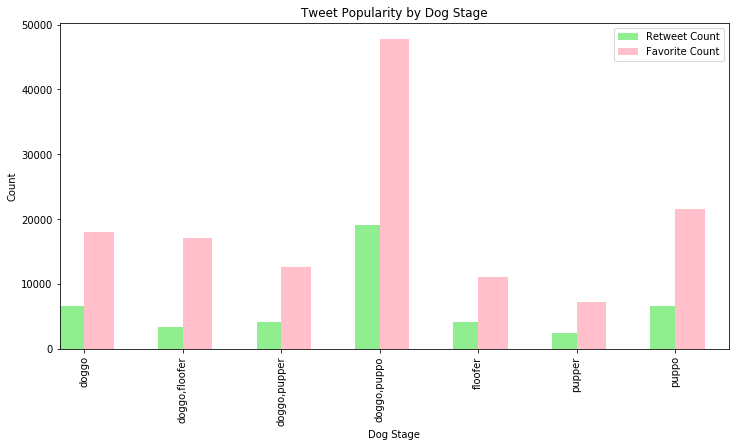

In [266]:
fig, ax = plt.subplots(figsize = (12,6))

#ax.bar(df_master.stage, df_master.rt_count, width=0.5, \
 #      color='lightgreen', align='center', label='Retweet Count')
#ax.bar(df_master.stage, df_master.fav_count, width=0.3, \
 #      color='pink', align='edge', label='Favorite Count')

df_master.groupby(['stage']).rt_count.mean().plot.bar(width=0.5, \
     color='lightgreen', align='center', label='Retweet Count')
df_master.groupby(['stage']).fav_count.mean().plot.bar(width=0.3, \
      color='pink', align='edge', label='Favorite Count')



ax.set_ylabel('Count')
ax.set_xlabel('Dog Stage')

ax.set_title('Tweet Popularity by Dog Stage')

plt.legend()
plt.show()

#### Conclusion: When puppos and doggos are together it gets the most favorites and retweets making it the most popular. The least average of rt and fav is for puppers.

### Insight 2:
We'll explore most submitted/common dog breeds in WeRateDogs:

In [268]:
print(df_master.p1.value_counts()[:3])
print(df_master.p2.value_counts()[:3])
print(df_master.p3.value_counts()[:3])

golden_retriever      136
labrador_retriever     94
pembroke               88
Name: p1, dtype: int64
labrador_retriever    95
golden_retriever      82
cardigan              72
Name: p2, dtype: int64
labrador_retriever    75
chihuahua             57
golden_retriever      45
Name: p3, dtype: int64


#### Conclusion: Retriever breeds are the most common breeds in the WeRateDogs.

### Insight 3:
We'll see the dog stage with the highest average rating:

In [269]:
df_master.groupby(['stage']).rating.mean()

stage
doggo            1.184722
doggo,floofer    1.100000
doggo,pupper     1.111111
doggo,puppo      1.300000
floofer          1.188889
pupper           1.073439
puppo            1.200000
Name: rating, dtype: float64

#### Conclusion: Here also, the average rating for puppo and doggo is higher than the other dog stages. Puppers get lower rating here too.